In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2020-07-04 17:59:32--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.18.176, 216.58.205.240, 172.217.21.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.18.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142,65M  5,99MB/s    in 34s     

2020-07-04 18:00:06 (4,14 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [3]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()


<zipfile.ZipFile filename='/tmp/horse-or-human.zip' mode='r'>


In [3]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

In [4]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse41-7.png', 'horse29-1.png', 'horse39-3.png', 'horse43-4.png', 'horse22-8.png', 'horse34-2.png', 'horse38-4.png', 'horse43-2.png', 'horse13-0.png', 'horse44-2.png']
['human07-20.png', 'human03-04.png', 'human08-24.png', 'human02-18.png', 'human16-12.png', 'human15-06.png', 'human11-09.png', 'human17-24.png', 'human11-17.png', 'human03-03.png']


In [5]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

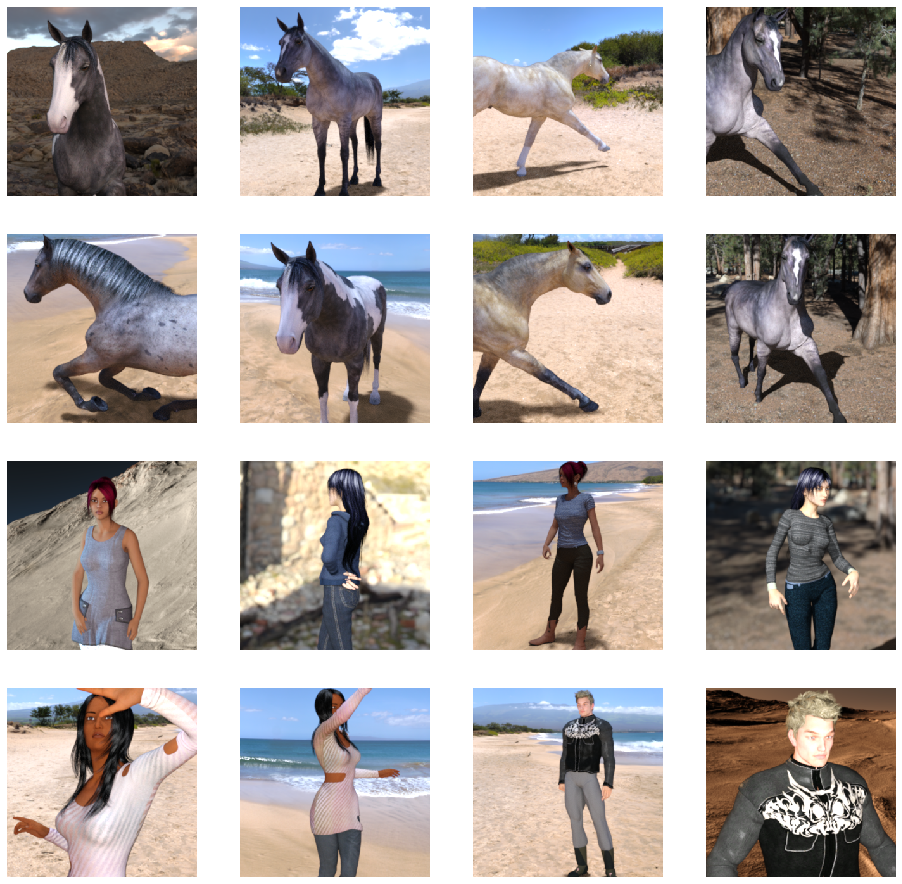

In [7]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()


In [8]:
import tensorflow as tf

In [9]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [11]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 1027 images belonging to 2 classes.


In [13]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1)

Train for 8 steps
Epoch 1/15
8/8 [==============================] - 56s 7s/step - loss: 0.9455 - accuracy: 0.5332
Epoch 2/15
8/8 [==============================] - 46s 6s/step - loss: 0.7552 - accuracy: 0.5795
Epoch 3/15
8/8 [==============================] - 46s 6s/step - loss: 0.6276 - accuracy: 0.6418
Epoch 4/15
8/8 [==============================] - 46s 6s/step - loss: 0.5712 - accuracy: 0.7909
Epoch 5/15
8/8 [==============================] - 46s 6s/step - loss: 0.6745 - accuracy: 0.7542
Epoch 6/15
8/8 [==============================] - 46s 6s/step - loss: 0.3471 - accuracy: 0.8365
Epoch 7/15
8/8 [==============================] - 46s 6s/step - loss: 0.3285 - accuracy: 0.8843
Epoch 8/15
8/8 [==============================] - 46s 6s/step - loss: 0.1212 - accuracy: 0.9499
Epoch 9/15
8/8 [==============================] - 47s 6s/step - loss: 0.5634 - accuracy: 0.8743
Epoch 10/15
8/8 [==============================] - 47s 6s/step - loss: 0.1942 - accuracy: 0.9021
Epoch 11/15
8/8 [====

In [35]:
import numpy as np
#from google.colab import files
from keras.preprocessing import image
#/home/elvin/Pictures/horse.jpg
#uploaded = files.upload()
# predicting images
path = "/home/elvin/Documents/deep_learning/images/image.png"
img = image.load_img(path, target_size=(300, 300))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
if classes[0]>0.5:
    print("is a human")
else:
    print("is a horse")

is a horse
